In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from Bio.Seq import Seq


In [9]:
matching = 2
mismatching = -1
gap = -1
arrows = None

In [3]:
def match_chars(A, B):
    if A == B:
        return matching
    else:
        return mismatching

In [4]:

def needleman_wunsch(seq1, seq2):
    m, n = len(seq2), len(seq1)  # length of two sequences
    #---------
    dt = np.dtype([('diagonal', np.str, 1),
                   ('up', np.str, 1), ('left', np.str, 1)])

    dir_matrix = np.zeros((m + 1, n + 1), dtype=dt)

    #---------
    final_matrix = np.zeros((m + 1, n + 1), dtype=int)      # the DP table
    # Calculate DynamicProgramming table
    for i in range(0, m + 1):
        final_matrix[i][0] = gap_penalty * i
        if i !=0:
            dir_matrix[i][0]['up'] = 'U'
    for j in range(0, n + 1):
        final_matrix[0][j] = gap_penalty * j
        if j !=0:
            dir_matrix[0][j]['left'] = 'L'
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            diagonal = final_matrix[i - 1][j - 1] + \
                match_chars(seq2[i - 1], seq1[j - 1])
            up = final_matrix[i - 1][j] + gap_penalty
            left = final_matrix[i][j - 1] + gap_penalty
            max_pointer = max(diagonal, up, left)
            final_matrix[i][j] = max_pointer
            if (diagonal == max_pointer):
                dir_matrix[i][j]['diagonal'] = 'D'
            if (up == max_pointer):
                dir_matrix[i][j]['up'] = 'U'
            if (left == max_pointer):
                dir_matrix[i][j]['left'] = 'L'
    # Traceback and compute the alignment
    align1, align2 = '', ''
    i, j = m, n  # start from the bottom right cell
    a = np.array([[0, 0, 0, 0]])

    first = True
    global arrows
    while i > 0 and j > 0:  # end toching the top or the left edge
        score_current = final_matrix[i][j]
        score_diagonal = final_matrix[i - 1][j - 1]
        score_up = final_matrix[i][j - 1]
        score_left = final_matrix[i - 1][j]
        #print("current ",i,j,end='')
        a[:, :2] = j, i
        if score_current == score_diagonal + match_chars(seq2[i - 1], seq1[j - 1]):
            align1 += seq2[i - 1]
            align2 += seq1[j - 1]
            i -= 1
            j -= 1
        elif score_current == score_left + gap_penalty:
            align1 += seq2[i - 1]
            align2 += '-'
            i -= 1
        elif score_current == score_up + gap_penalty:
            align1 += '-'
            align2 += seq1[j - 1]
            j -= 1
        a[:, 2:] = j, i
        if first:
            # First loop copy a
            arrows = np.copy(a)
            first = False
        else:
            # Concatenate origin-target
            arrows = np.concatenate((arrows, a), axis=0)
    a[:, :2] = a[:, 2:]

    # Finish tracing up to the top left cell
    while i > 0:
        align1 += seq2[i - 1]
        align2 += '-'
        i -= 1
        a[:, 2:] = j, i
        arrows = np.concatenate((arrows, a), axis=0)
    while j > 0:
        align1 += '-'
        align2 += seq1[j - 1]
        j -= 1
        a[:, 2:] = j, i
        arrows = np.concatenate((arrows, a), axis=0)
    return final_matrix, dir_matrix,align2,align1

In [5]:
#----------------visual plot---------------
def plot(seq1,seq2,final_matrix,dir_matrix):

    plt.rcParams["figure.figsize"] = 4, 5
    param = {"grid.linewidth": 1.6,
             "grid.color": "lightgray",
             "axes.linewidth": 1.6,
             "axes.edgecolor": "lightgray"}
    plt.rcParams.update(param)

    fig, ax = plt.subplots()
    ax.set_xlim(-1.5, final_matrix.shape[1] - .5)
    ax.set_ylim(-1.5, final_matrix.shape[0] - .5)
    ax.invert_yaxis()
    for i in range(final_matrix.shape[0]):
        for j in range(final_matrix.shape[1]):
            ax.text(j, i, final_matrix[i, j], ha="center", va="center")
    for i, l in enumerate(seq1):
        ax.text(i + 1, -1, l, ha="center", va="center", fontweight="semibold")
    for i, l in enumerate(seq2):
        ax.text(-1, i + 1, l, ha="center", va="center", fontweight="semibold")
    
    ax.xaxis.set_minor_locator(ticker.FixedLocator(
        np.arange(-1.5, final_matrix.shape[1] - .5, 1)))
    ax.yaxis.set_minor_locator(ticker.FixedLocator(
        np.arange(-1.5, final_matrix.shape[1] - .5, 1)))
    plt.tick_params(axis='both', which='both', bottom='off', top='off',
                    left="off", right="off", labelbottom='off', labelleft='off')
    ax.grid(True, which='minor')
    
    
    arrowprops = dict(facecolor='red', alpha=0.5, lw=0,
                      shrink=0.2, width=2, headwidth=7, headlength=7)
    
    # all paths
    for i in range(0, dir_matrix.shape[0]):
        for j in range(0, dir_matrix.shape[1]):
            if(dir_matrix[i][j]['left'] != ''):
                ax.annotate("", xy=(j - 1, i),
                            xytext=(j, i), arrowprops=arrowprops)
            if(dir_matrix[i][j]['diagonal'] != ''):
                ax.annotate("", xy=(j - 1, i - 1),
                            xytext=(j, i), arrowprops=arrowprops)
            if(dir_matrix[i][j]['up'] != ''):
                ax.annotate("", xy=(j, i - 1),
                            xytext=(j, i), arrowprops=arrowprops)
    
    # optimal path
    arrowprops = dict(facecolor='green', alpha=0.5, lw=0,
                      shrink=0.2, width=2, headwidth=7, headlength=7)
    for i in range(arrows.shape[0]):
        ax.annotate("", xy=arrows[i, 2:],
                    xytext=arrows[i, :2], arrowprops=arrowprops)
    plt.show()

In [10]:
seq1 = Seq("ACGCTG")
seq2 = Seq("CATGT")

In [11]:
final_matrix, dir_matrix,align2,align1 = needleman_wunsch(seq1, seq2)

In [12]:
print("global Alignment:")
print("\t"*4,align2[::-1])
print("\t"*4,align1[::-1])

global Alignment:
				 ACGCTG-
				 -C-ATGT


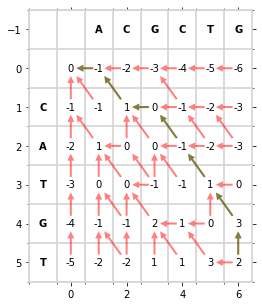

In [14]:
plot(seq1,seq2,final_matrix,dir_matrix)

In [15]:
matching = 1
mismatching = -1
gap = -2
arrows = None

In [17]:
seq1 = Seq("GGTTGACTA")
seq2 = Seq("TGTTACGG")
final_matrix, dir_matrix,align2,align1 = needleman_wunsch(seq1, seq2)

In [18]:
print("global Alignment:")
print("\t"*4,align2[::-1])
print("\t"*4,align1[::-1])

global Alignment:
				 GGTTGACTA
				 TGTT-ACGG


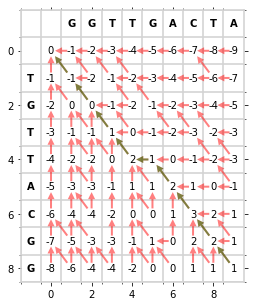

In [21]:
plot(seq1,seq2,final_matrix,dir_matrix)